# Modelar el problema

Como el objetivo es identificar transacciones que evidencian un comportamiento de fraccionamiento(Mala practica transaccional), recurro a mi experiencia y a la información academica para encontrar formas de modelar los datos

* **Modelo de aprendizaje no supervisado**: Como no tengo etiquetas con las que pueda entrenar un modelo de clasificación, se me ocurre crear una muestra y entregar estos datos a un algoritmo como DBSCAN que es muy bueno para conjuntos de datos que tienen ruido y valores atipicos, ademas no le tengo que asignar un valor de K pues el mismo es capaz de crear los grupos en funcion de los parametros. Con este modelo podria etiquetar los datos para n meses y luego emplear un modelo de clasificación para la totalidad de la data. 

Lo interesante es poder determinar cuales son los valores en los features para que sea una mala practica transaccional. De manera heuristica pensaria que una transaccion es sospechos de malas practicas cuando el volumen de transacciones en la ventana de tiempo es muy grande, y el promedio del tiempo y del transaction amount es pequeño; tambien entra a jugar la relacion con el total acumulado que se ha transferido.

El gran interrogante es, como me aproximo a esos valores. Pues bien, manos a la obra a experimentar con este primer modelo como nos va.

### Importar librerias

In [3]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Leer la data

In [47]:
route = 'day_featured_data_0002.parquet'
df= dd.read_parquet(route)

fet_df = df.compute()

### Muestreo

Para iniciar la iteracion con los diferentes modelos, debo escoger una muestra representativa ya que no es optimo trabajar con todos los datos. Ademas tengo limitaciones de procesamiento en mi maquina.

Aprovechando la naturaleza de los datos, voy a emplear un ```muestreo estratificado```. Como la variable tiempo es determinante y conductora del evento, voy a seleccionar todas las transacciones de un mes que presente un comportamiento similar asi:

* meses que tengan en promedio 2M de transacciones en total: pueden ser feb,jun,ago
* meses cuyos maximos y minimos por dia esten comprendidos en la mediana de la distribución: pueden ser jun,ene,ago para la max ; jun, ago para la min.

Entonces, **los meses de muestreo seran agosto y junio**



In [68]:
sample_data = fet_df[fet_df['date'].dt.month.isin([6,8])]
sample_data['total_time_hr'] = ((sample_data['total_transactions'] * sample_data['avg_time_min_between_transactions'])/60).round(2)

C:\Users\57304\AppData\Local\Temp\ipykernel_19580\904467796.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data['total_time_hr'] = ((sample_data['total_transactions'] * sample_data['avg_time_min_between_transactions'])/60).round(2)


In [65]:
total_features_sample_data = sample_data [[ 'time_diff_minutes','transaction_amount', 
                                      'total_transactions', 'total_transaction_amount', 
                                      'avg_time_min_between_transactions','avg_amount_transactions', 'total_time_hr']]

total_features_sample_data

,time_diff_minutes,transaction_amount,total_transactions,total_transaction_amount,avg_time_min_between_transactions,avg_amount_transactions,total_time_hr
1430450,0.000000,59.445,1,59.445,0.000000,59.445000,0.00
1479724,0.000000,118.889,1,118.889,0.000000,118.889000,0.00
519187,0.000000,237.778,1,237.778,0.000000,237.778000,0.00
1991159,0.000000,118.889,1,118.889,0.000000,118.889000,0.00
2135846,0.000000,35.667,1,35.667,0.000000,35.667000,0.00
...,...,...,...,...,...,...,...
2030509,1438.000000,416.112,3,1129.446,479.350000,376.482000,23.97
2030507,0.050000,416.112,4,1545.558,359.525000,386.389500,23.97
455161,2.000000,594.446,6,3210.008,239.816667,535.001333,23.98
2030506,1.033333,416.112,5,1961.670,287.826667,392.334000,23.99


In [66]:
y_features_sample_data.to_csv('year_sample_data_model.csv')

Voy a intriducir el concepto de ```label_stage```, esto es un etiquetado temporal que puede inferirse de los datos cuando es predominante un patron avalado conceptualmente. En este caso, deduciremos un comportamiento sin fraccionamiento transaccional cuando el total de transacciones entre una pareja transaccional es igual a 1 en una ventana de tiempo de 24 horas.  

In [69]:
# Mascara para seleccionar por cada pareja transaccional en una fecha la ultima transaccion que hizo en la ventana de tiempo.
mask = sample_data['total_transactions'] == sample_data.groupby(['date', 'account_number', 'subsidiary'])['total_transactions'].transform('max')

# Filtrar el DataFrame original con la máscara
mask_sample_data = sample_data[mask]
mask_sample_data.count()

merchant_id                          3657709
_id                                  3657709
subsidiary                           3657709
transaction_date                     3657709
account_number                       3657709
user_id                              3657709
transaction_amount                   3657709
transaction_type                     3657709
date                                 3657709
total_transactions                   3657709
total_transaction_amount             3657709
time_diff_minutes                    3657709
avg_time_min_between_transactions    3657709
avg_amount_transactions              3657709
total_time_hr                        3657709
dtype: int64

Ahora que tengo un registro unico por transaccion para cada dia, voy a revisar la distribución del label_stage. Si lo encuentro desbalanceado debo balancear cada una de las class_stage para el procesamiento en el modelo. 

In [70]:
transactions_counts = mask_sample_data.total_transactions.value_counts()

transactions_class = {    
                      'frecuencia_transaccional': ['1', '> 1'],
                      'total_transacciones': [transactions_counts.get(1, 0), transactions_counts[transactions_counts.index != 1].sum()]
                      }

transactions_counts_frec = pd.DataFrame(transactions_class)

# calcular el total de transacciones
total_transactions = transactions_counts_frec['total_transacciones'].sum()

transactions_counts_frec['porcentaje'] = (transactions_counts_frec['total_transacciones'] / total_transactions) * 100
transactions_counts_frec

,frecuencia_transaccional,total_transacciones,porcentaje
0,1,3431147,93.805904
1,> 1,226562,6.194096


In [71]:
mask_sample_data.loc[mask_sample_data['total_transactions'] == 1, 'label_stage'] = 1
mask_sample_data.loc[mask_sample_data['total_transactions'] > 1, 'label_stage'] = 0

#Obtener la cantidad mínima de registros entre las clases
min_class_count = mask_sample_data['label_stage'].value_counts().min()

# Balancear el DataFrame
balanced_sample_data = mask_sample_data.groupby('label_stage').apply(lambda x: x.sample(n=min_class_count, random_state=42)).reset_index(drop=True)

balanced_sample_data.head(2)

C:\Users\57304\AppData\Local\Temp\ipykernel_19580\2380776156.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mask_sample_data.loc[mask_sample_data['total_transactions'] == 1, 'label_stage'] = 1


,merchant_id,_id,subsidiary,transaction_date,account_number,user_id,transaction_amount,transaction_type,date,total_transactions,total_transaction_amount,time_diff_minutes,avg_time_min_between_transactions,avg_amount_transactions,total_time_hr,label_stage
0,075d178871d8d48502bf1f54887e52fe,56a0165f3d6473c23aa27fc17f7a0e2f,76c5379326dd95b81ed514f40c10e79a,2021-06-10 11:00:22,af010e1fd09594e9afbfeaa70e8b5d10,04493ec13f5565c93ce6b644e592bec0,594.446,CREDITO,2021-06-10,3,1545.559,2.583333,1.338889,515.186333,0.07,0.0
1,817d18cd3c31e40e9bff0566baae7758,ec46fc9337b2d29224b346bac37705cc,bd551ce493fd8b20427c7ce2a8dc5969,2021-06-10 09:52:25,1c8fd0e6f330d2022e1da7cd97935162,5827a3de6152b6c6df718cc2d821f5d4,71.333,DEBITO,2021-06-10,2,784.668,1.100000,0.550000,392.334000,0.02,0.0


¡Listo! He balanceado la data. Tengo el mismo numero de registros tanto para total de transacciones > 1 como los que son = 1, los cuales sabemos que no dan indicio de fraccionamiento transaccional

Filtro el dataset por las columnas del feature engineering 

In [72]:
data_to_model = balanced_sample_data [[ 'time_diff_minutes','transaction_amount', 
                                      'total_transactions', 'total_transaction_amount', 
                                      'avg_time_min_between_transactions','avg_amount_transactions', 'total_time_hr']]
data_to_model

,time_diff_minutes,transaction_amount,total_transactions,total_transaction_amount,avg_time_min_between_transactions,avg_amount_transactions,total_time_hr
0,2.583333,594.446,3,1545.559,1.338889,515.186333,0.07
1,1.100000,71.333,2,784.668,0.550000,392.334000,0.02
2,1.216667,594.446,2,1188.892,0.608333,594.446000,0.02
3,272.016667,23.778,2,47.556,136.008333,23.778000,4.53
4,608.233333,59.445,2,130.778,304.116667,65.389000,10.14
...,...,...,...,...,...,...,...
453119,0.000000,40.422,1,40.422,0.000000,40.422000,0.00
453120,0.000000,59.445,1,59.445,0.000000,59.445000,0.00
453121,0.000000,107.000,1,107.000,0.000000,107.000000,0.00
453122,0.000000,59.445,1,59.445,0.000000,59.445000,0.00


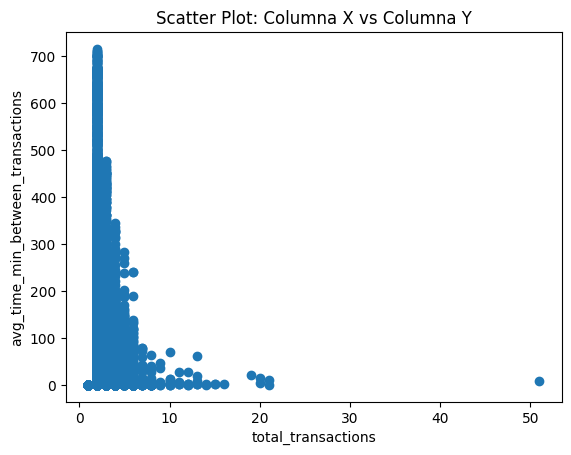

In [73]:
# Extraer las columnas para el scatter plot
x = data_to_model['total_transactions']
y = data_to_model['avg_time_min_between_transactions']

# Crear el gráfico de dispersión
plt.scatter(x, y)

# Agregar etiquetas y título
plt.xlabel('total_transactions')
plt.ylabel('avg_time_min_between_transactions')
plt.title('Scatter Plot: Columna X vs Columna Y')

# Mostrar el gráfico
plt.show()

c:\Users\57304\Desktop\nequi_prueba\nequi_code\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


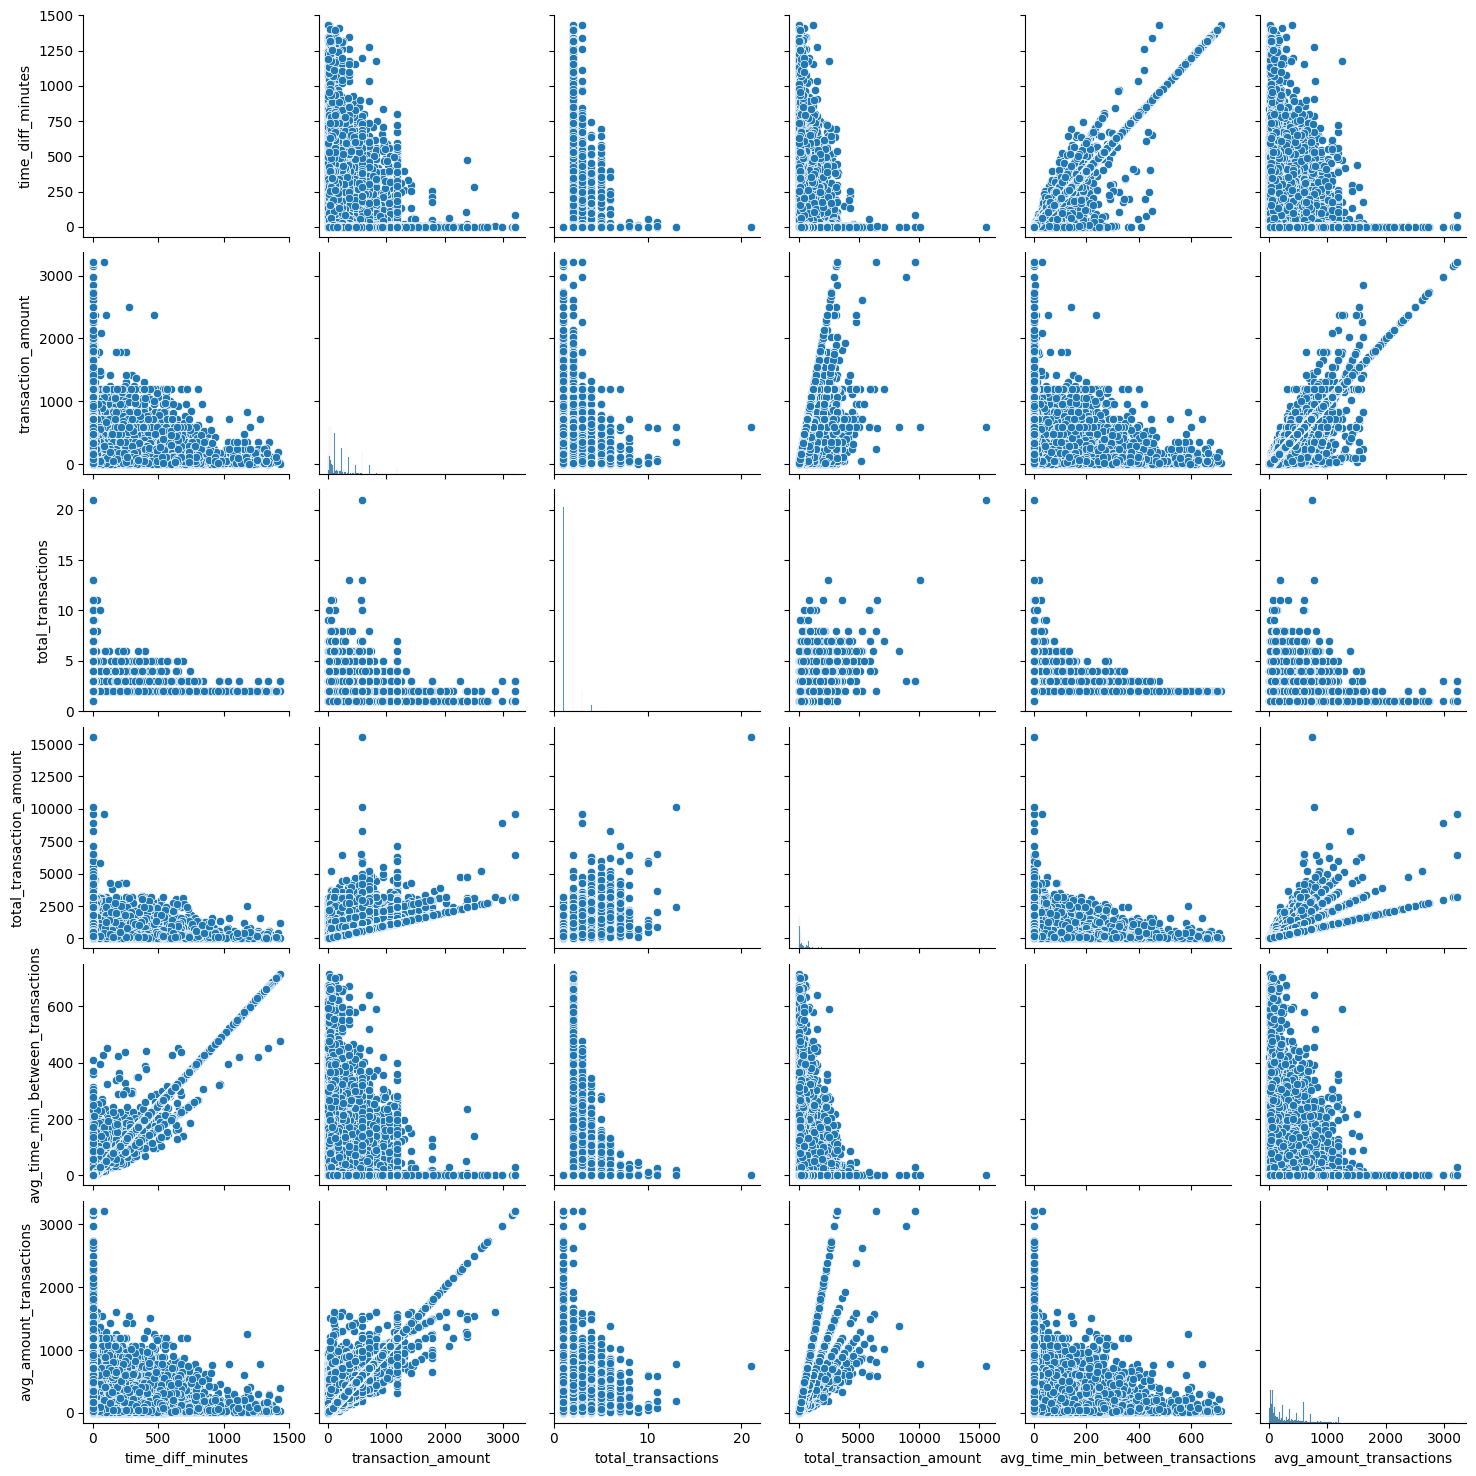

In [21]:
sns.pairplot(data_to_model)

# Mostrar el gráfico
plt.show()

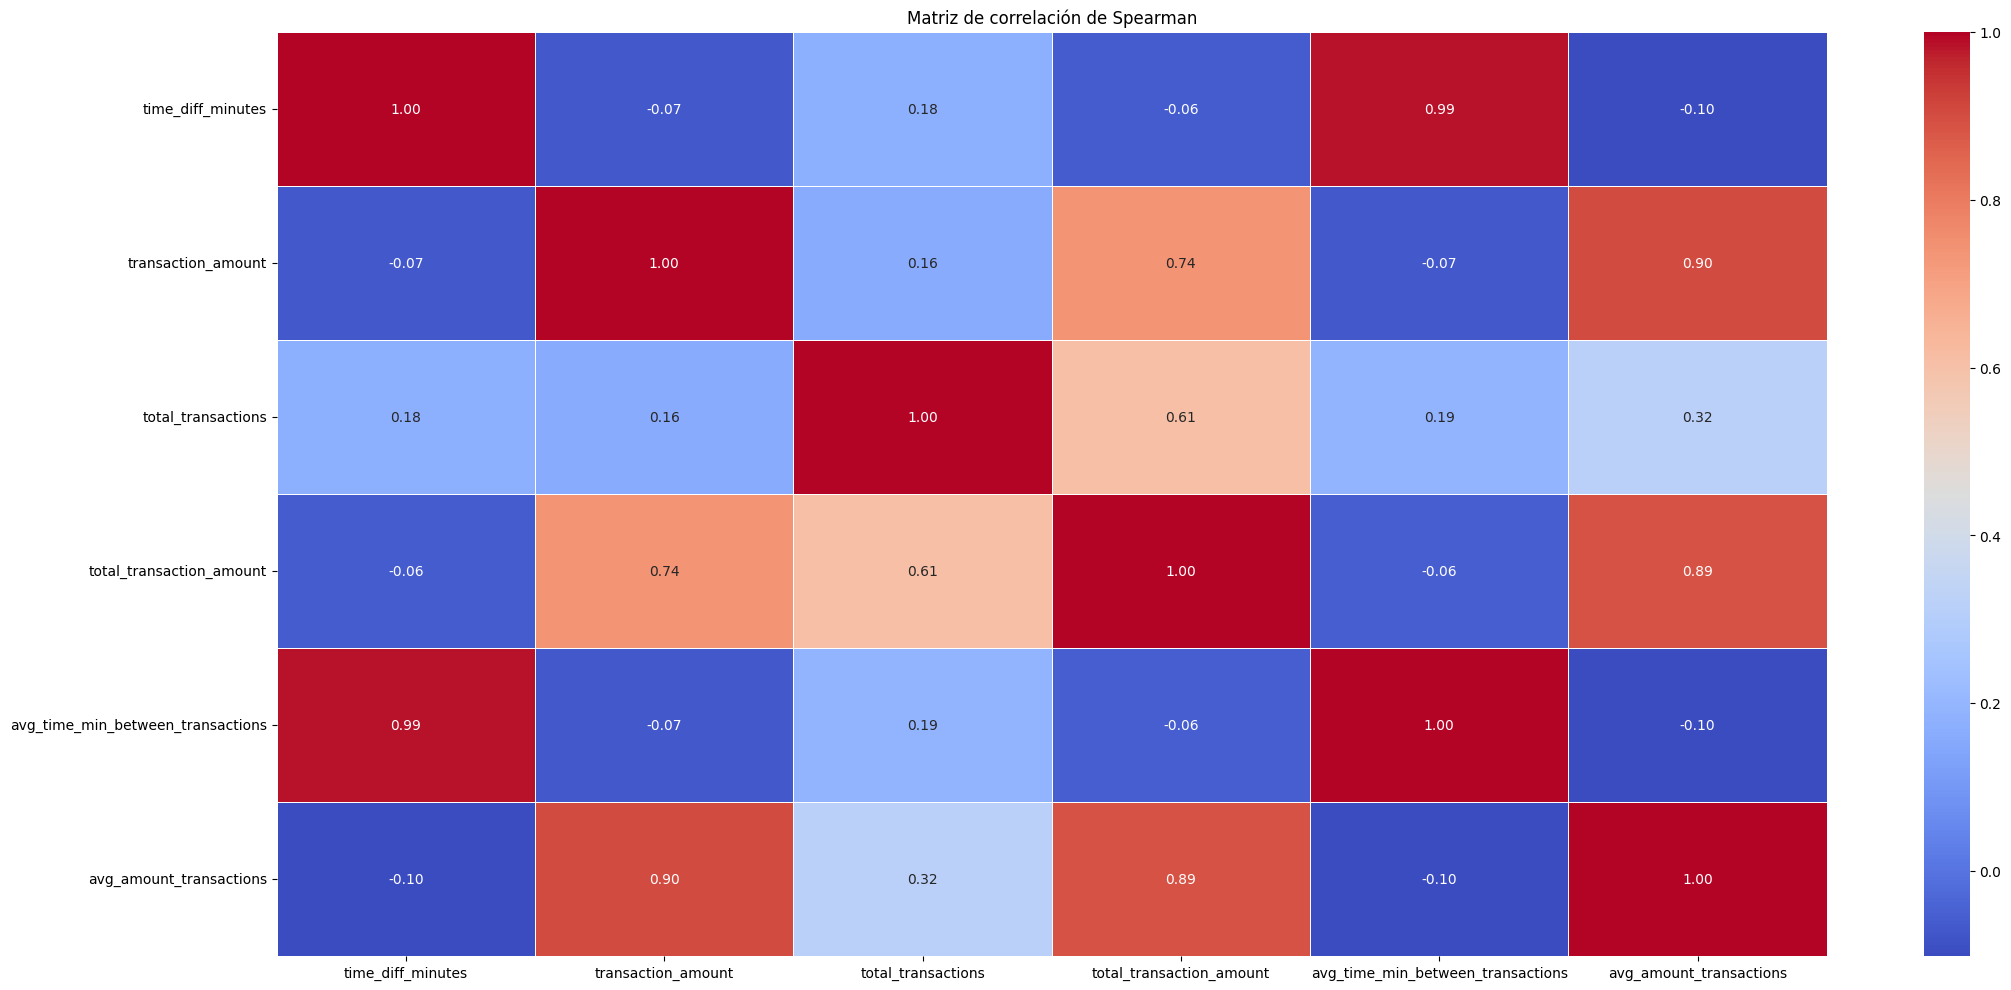

In [23]:
corr_spearman = data_to_model.corr(method='pearson')


plt.figure(figsize=(25, 12))
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Matriz de correlación de Spearman')
plt.show()

### **Prueba 1**

#### Aprendizaje no supervisado, DBSCAN

Realice varias experimentaciones con este algoritmo:

* Probe con los datos crudos provenientes del feature engineering, tardo mucho tiempo procesando toda la muestra que describi anteriormente,de hecho me toco pararlo al tiempo 5h y 24 minutos porque seguia procesando y en definitiva no es una solucion optima
* Escale la data usando el metodo RobustScaler de scikit-learn. Elegi este metodo por es uan buena opcion para datos cons distribuciones no normales y valores atipicos, este metodo va a escalar la data manteniendo esas proporciones entonces no se afectan los datos. Si bien logre un procesamiento mas rapido el algoritmo no fue capaz de segmentar mas de un grupo, aun cuando evalue diferentes hiperparametros. 


Este procesamiento lo ejecute desde Colab asi que voy a poner en este notebook el codigo y las imagenes + resultados de lo que obtuve alla. 

##### Escalar la data

In [74]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
scaler = RobustScaler()

In [75]:
sample_date_scaled = scaler.fit_transform(data_to_model)
sample_date_scaled = pd.DataFrame(sample_date_scaled, columns = data_to_model.columns)
sample_date_scaled

,time_diff_minutes,transaction_amount,total_transactions,total_transaction_amount,avg_time_min_between_transactions,avg_amount_transactions,total_time_hr
0,1.631579,1.904765,1.5,2.068516,1.530159,1.011112,2.333333
1,0.694737,-0.190478,0.5,0.883331,0.628571,0.666667,0.666667
2,0.768421,1.904765,0.5,1.512962,0.695238,1.233335,0.666667
3,171.800000,-0.380951,0.5,-0.264815,155.438095,-0.366667,151.000000
4,384.147368,-0.238093,0.5,-0.135186,347.561905,-0.250001,338.000000
...,...,...,...,...,...,...,...
453119,0.000000,-0.314287,-0.5,-0.275927,0.000000,-0.320002,0.000000
453120,0.000000,-0.238093,-0.5,-0.246296,0.000000,-0.266666,0.000000
453121,0.000000,-0.047619,-0.5,-0.172223,0.000000,-0.133334,0.000000
453122,0.000000,-0.238093,-0.5,-0.246296,0.000000,-0.266666,0.000000


##### PCA

In [76]:
pca = PCA()
pca.fit(sample_date_scaled)
pca_data_scaled = pca.transform(sample_date_scaled)
pca_data_scaled

array([[-2.42955270e+01,  2.81665538e-01,  3.83973398e-01, ...,
         8.54566404e-01,  5.02880197e-01, -3.63129288e-01],
       [-2.63054252e+01, -2.93369569e-01, -2.48728518e-03, ...,
         7.58696791e-01, -4.46626450e-01,  2.87694592e-01],
       [-2.62253072e+01, -3.36394422e-01, -1.26556328e-02, ...,
        -1.34912438e-01,  2.18887804e-01, -8.24439622e-02],
       ...,
       [-2.74552656e+01, -3.27938225e-01, -6.54169772e-02, ...,
        -3.57092691e-01, -1.01623396e-01, -7.23839299e-02],
       [-2.74550020e+01, -3.28381075e-01, -6.79753157e-02, ...,
        -2.71381381e-01, -1.30957110e-01, -9.81379596e-02],
       [-2.74553315e+01, -3.27827511e-01, -6.47773791e-02, ...,
        -3.78520969e-01, -9.42898134e-02, -6.59452871e-02]])

In [77]:
var = pca.explained_variance_ratio_
print(var)

[9.86369296e-01 1.18785011e-02 1.47675556e-03 2.12610770e-04
 5.10509070e-05 9.29827980e-06 2.48710881e-06]


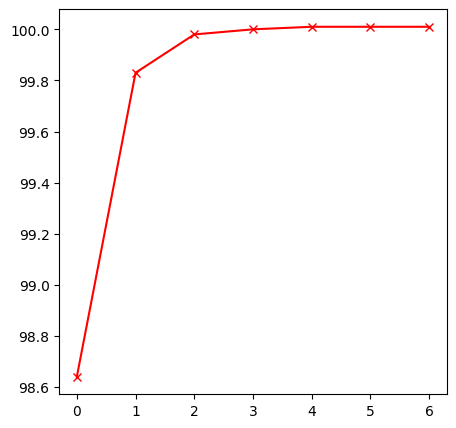

In [78]:
cum_var = np.cumsum(np.round(var, decimals = 4)*100)
plt.figure(figsize = (5,5))
plt.plot(cum_var, 'r-x')
plt.show()

In [84]:
pca_data_standard = pd.DataFrame(pca_data_scaled)
pca_data_standard.drop([3,4,5,6], axis=1, inplace= True)
pca_data_standard

,0,1,2
0,-24.295527,0.281666,0.383973
1,-26.305425,-0.293370,-0.002487
2,-26.225307,-0.336394,-0.012656
3,249.045502,-4.967336,-1.976802
4,591.005068,-10.463788,-4.194778
...,...,...,...
453119,-27.454897,-0.328558,-0.068999
453120,-27.455002,-0.328381,-0.067975
453121,-27.455266,-0.327938,-0.065417
453122,-27.455002,-0.328381,-0.067975


<Figure size 640x480 with 0 Axes>

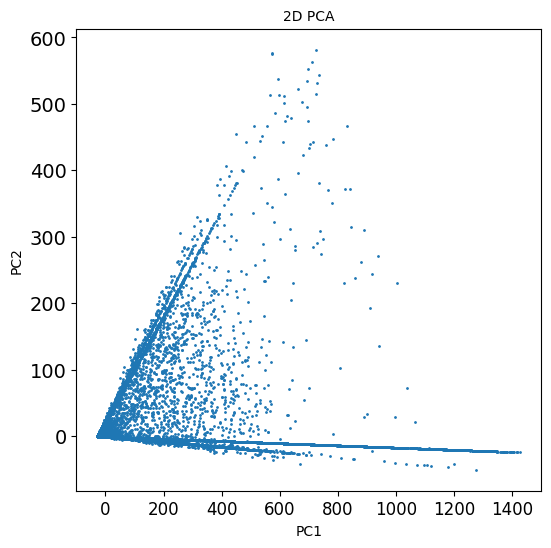

In [80]:
plt.figure()
plt.figure(figsize=(6,6))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('PC1',fontsize=10)
plt.ylabel('PC2',fontsize=10)
plt.title("2D PCA",fontsize=10)

plt.scatter(pca_data_standard[0], pca_data_standard[1], s = 1)

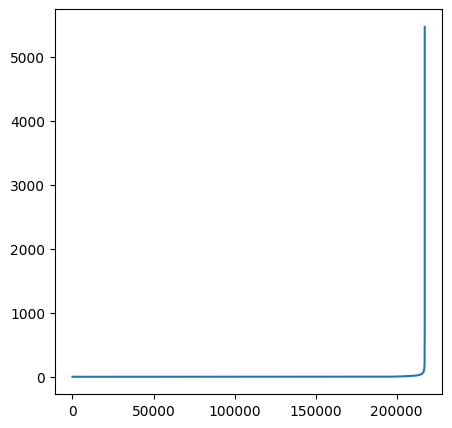

In [86]:
from sklearn.neighbors import NearestNeighbors
# busca los dos vecinos mas cercanos cada punto
neighbors = NearestNeighbors(n_neighbors= 2)
neighbors_fit = neighbors.fit(sample_date)
# Calcula las distancias y los índices de los vecinos más cercanos para cada punto en el conjunto de datos.
distances, indices = neighbors_fit.kneighbors(sample_date)

#Ordena las distancias de manera ascendente
distances = np.sort(distances, axis= 0)
#obtenemos las distancias a los vecinos más cercanos distintos de cada punto
distances = distances[:,1]

# Realiza un gráfico de líneas con las distancias a los vecinos más cercanos. 
#El eje x representará los índices de los puntos en el conjunto de datos, y el eje y representará las distancias a los vecinos más cercanos. 
#Este gráfico permite visualizar cómo disminuyen las distancias a medida que avanzamos hacia los vecinos más cercanos
fig = plt.figure(figsize =(5,5))
plt.plot(distances)

In [83]:
from kneed import KneeLocator
kneedle = KneeLocator(x = range(1, len(neigh_dist)+1), y = k_dist, S = 1.0, 
                      curve = "concave", direction = "increasing", online=True)

# get the estimate of knee point
print(kneedle.knee_y)

69.10169716175457


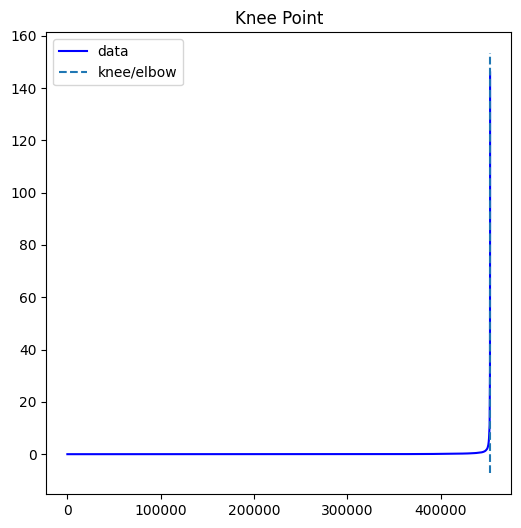

In [85]:
kneedle.plot_knee()
plt.show()

In [ ]:
# Arreglos para probar diferentes valores de los parametros
eps_values = np.arange(1.0 , 3.0, 0.10)
min_samples = np.arange(3,12)

In [ ]:
from itertools import product
dbscan_paramns = list(product(eps_values, min_samples))
no_of_cluster= []
sil_score = []

for p in dbscan_paramns:
  y_dbscan = DBSCAN(eps= p[0], min_samples = p[1]).fit_predict(sample_date)
  try: 
    sil_score.append(silhouette_score(sample_date, y_dbscan))
  except: 
    sil_score.append(0)
  no_of_cluster.append(len(np.unique(y_dbscan)))

In [ ]:
df_param_tunning = pd.DataFrame.from_records(dbscan_paramns, columns =['Eps', 'Min_samples'])
df_param_tunning['sil_score'] = sil_score
df_param_tunning['n_clusters'] = no_of_cluster

In [ ]:
pivot_1 = pd.pivot_table(df_param_tunning, values= 'sil_score', columns = 'Eps', index = 'Min_samples')
pivot_2 = pd.pivot_table(df_param_tunning, values= 'n_clusters', columns = 'Eps', index = 'Min_samples')

In [ ]:
fig, ax = plt.subplots(figsize = (18,6))
sns.heatmap(pivot_1, annot= True, annot_kws = {'size':10}, cmap ='coolwarm' , ax=ax)
plt.show()

![Silhoutte score](graficos\silhoutte_score.png)

In [ ]:
fig, ax = plt.subplots(figsize = (18,6))
sns.heatmap(pivot_2, annot= True, annot_kws = {'size':10}, cmap ='coolwarm' , ax=ax)
plt.show()

![Silhoutte score](graficos\num_clusters.png)

Desarrolle esta grilla de parametros y metricas y no tuve muchas variaciones. El indice de silueta es cero porque la representacion de los features(uan muestra seleccionada aleatoriamente sobre la muestra estratificada)en el espacio como puntos estan todos muy cercanos entonces el no precisa de encontrar grupos. Tambien las limitaciones de procesamiento hacen que definitivamente este algoritmo no sea optimo para grandes volumenes de datos o por lo menos un volumne suficiente para generar etiquetas con mucha precision y entrenar un modelo de clasificación para la demas data.

Este modelo queda descartado